## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/rdelaviz/.fastai/data/mnist_png/testing'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/models')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [9]:
doc(ImageList)

In [13]:
il.get_label_cls

<bound method ItemList.get_label_cls of ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/rdelaviz/.fastai/data/mnist_png>

In [7]:
defaults

namespace(cmap='viridis', cpus=16, device=device(type='cuda'), extra_callback_fns=None, extra_callbacks=None, lr=slice(None, 0.003, None), return_fig=False, silent=False, wd=0.01)

In [15]:
defaults.cmap='binary'

In [16]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/rdelaviz/.fastai/data/mnist_png

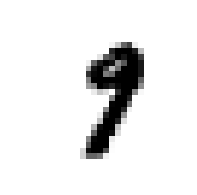

In [17]:
il[0].show()

In [20]:
doc(il.split_by_list)

In [18]:
sd = il.split_by_folder(train='training', valid='testing')

In [21]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/rdelaviz/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/rdelaviz/.fastai/data/mnist_png;

Test: None

In [22]:
(path/'training').ls()

[PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/rdelaviz/.fastai/data/mnist_png/training/0')]

In [23]:
ll = sd.label_from_folder()

In [24]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/rdelaviz/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /home/rdelaviz/.fastai/data/mnist_png;

Test: None

In [26]:
x,y = ll.train[0]

9 torch.Size([1, 28, 28])


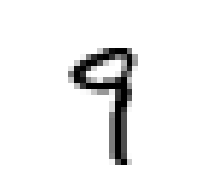

In [27]:
x.show()
print(y,x.shape)

In [28]:
doc(rand_pad)

In [35]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [36]:
tfms

([RandTransform(tfm=TfmPixel (pad), kwargs={'padding': 3, 'mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 28, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [])

In [37]:
ll = ll.transform(tfms)

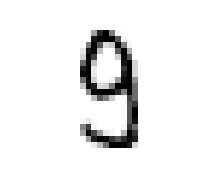

In [51]:
ll.valid[1000][0].show()

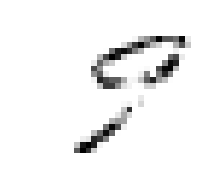

In [48]:
ll.train[1000][0].show()

In [52]:
bs = 128

In [53]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [54]:
x,y = data.train_ds[0]

9


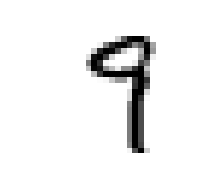

In [55]:
x.show()
print(y)

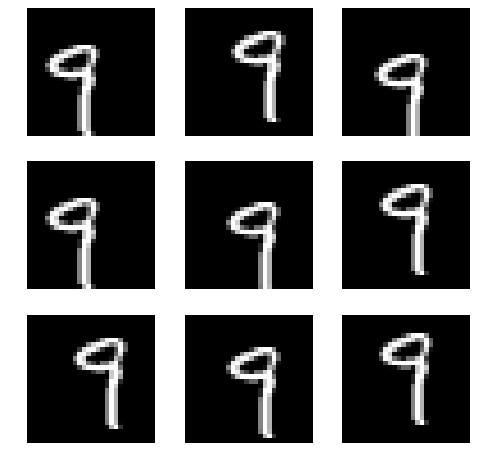

In [56]:
def _plot(i,j,ax): 
    data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

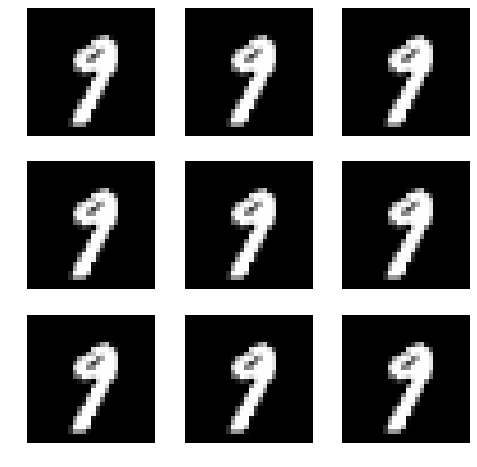

In [58]:
def _plotv(i,j,ax): 
    data.valid_ds[0][0].show(ax, cmap='gray')
plot_multi(_plotv, 3, 3, figsize=(8,8))

In [59]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

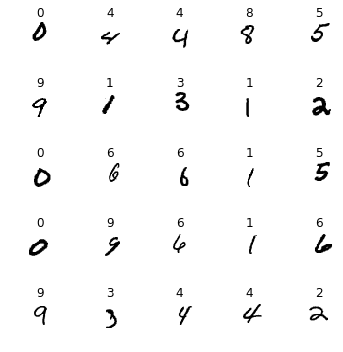

In [61]:
data.show_batch(rows=5, figsize=(5,5))

### Basic CNN with batchnorm

In [67]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [68]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [69]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Flatten()
)

In [70]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [71]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [72]:
xb = xb.cuda()

In [73]:
model(xb).shape

torch.Size([128, 10])

In [74]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


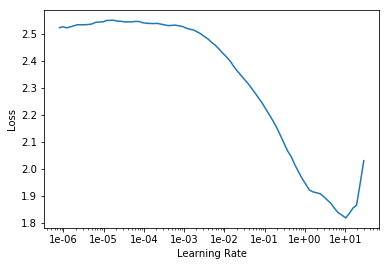

In [75]:
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.227497,0.151799,0.948800,00:06
1,0.124450,0.096961,0.970600,00:06
2,0.068828,0.037202,0.988000,00:06


### Refactor

In [77]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [78]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [79]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [80]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.257956,0.412882,0.871200,00:05
1,0.216774,0.216770,0.930500,00:05
2,0.169908,0.150787,0.951400,00:05
3,0.150254,0.114980,0.964400,00:05
4,0.124767,0.081167,0.974300,00:05
5,0.110457,0.080653,0.976000,00:06
6,0.095930,0.055972,0.982400,00:05
7,0.061953,0.041126,0.987800,00:06
8,0.057098,0.035204,0.988700,00:05
9,0.046249,0.030754,0.990000,00:06


### Resnet-ish

In [81]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [83]:
doc(res_block)

In [84]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [86]:
doc(MergeLayer)

In [85]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [87]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [88]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [89]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


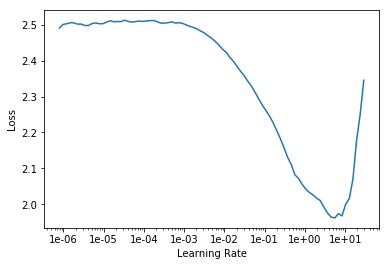

In [90]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [91]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.244023,0.306603,0.910700,00:10
1,0.148205,0.177189,0.941000,00:11
2,0.110816,0.193361,0.941400,00:11
3,0.090216,0.053688,0.983700,00:11
4,0.070840,0.064278,0.979900,00:11
5,0.066527,0.102080,0.966700,00:11
6,0.058164,0.054997,0.981900,00:11
7,0.047731,0.053748,0.982900,00:11
8,0.035075,0.022592,0.993400,00:10
9,0.029221,0.016889,0.994500,00:11


In [92]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________

## fin